#任务
请完成以下任务。

1，根据失败原因建立订单分布：分配司机前和后的取消，以及订单拒绝的原因。分析结果图。哪个类别的订单数量最多？
2，按小时绘制失败订单分布。是否有某些小时存在某种类别的异常高比例？哪些小时是最失败的？这可以如何解释？
3，按小时绘制有司机和无司机取消的平均取消时间。如果数据中存在任何异常值，最好将其删除。我们可以从这个图中得出什么结论？
4，按小时绘制平均到达时间的分布。这个图如何解释？
3，bonus六边形。使用h3和folium包，计算大小为8的六边形中包含原始数据集中80%的所有订单，并在地图上可视化这些六边形，将它们按失败次数着色。

数据描述
我们有两个数据集：data_orders和data_offers，两者都以CSV格式存储。data_orders数据集包含以下列：

order_datetime - 订单时间
origin_longitude - 订单的经度
origin_latitude - 订单的纬度
m_order_eta - 订单到达前的时间
order_gk - 订单号
order_status_key - 状态，一个枚举，包含以下映射：
4 - 客户取消，
9 - 系统取消，即拒绝
is_driver_assigned_key - 是否已分配司机
cancellation_time_in_seconds - 取消前经过多少秒
data_offers数据集是一个简单的映射，包含2列：

order_gk - 订单号，与orders数据集中的相同列相关
offer_id - 报价ID

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载数据
orders = pd.read_csv('datasets/data_orders.csv')
offers = pd.read_csv('datasets/data_offers.csv')

# change order_datetime from string to datetime format
orders['order_datetime'] = pd.to_datetime(orders['order_datetime'])


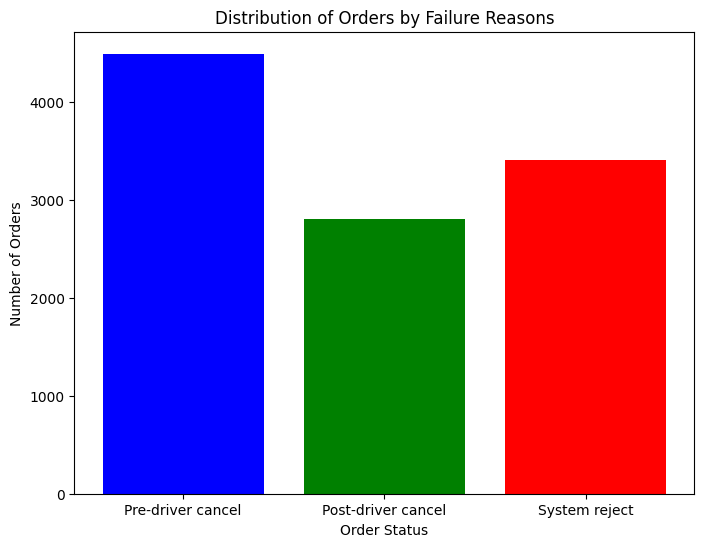

In [49]:
# 1. 建立订单失败原因分布
# 将订单分为以下几类：
# - 分配司机前取消的订单
# - 分配司机后取消的订单
# - 被系统拒绝的订单（状态为9）

pre_driver_cancel = orders[(orders['is_driver_assigned_key'] == 0) & (orders['order_status_key'] == 4)]
post_driver_cancel = orders[(orders['is_driver_assigned_key'] == 1) & (orders['order_status_key'] == 4)]
system_reject = orders[orders['order_status_key'] == 9]

# 统计每种类别的订单数量
counts = [len(pre_driver_cancel), len(post_driver_cancel), len(system_reject)]
categories = ['Pre-driver cancel', 'Post-driver cancel', 'System reject']

# 绘制柱状图
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'green', 'red'])
plt.xlabel('Order Status')
plt.ylabel('Number of Orders')
plt.title('Distribution of Orders by Failure Reasons')
plt.show()


根据取消的分部来看，用户取消的比系统取消的人数要多，并且在用户取消的里面，更多的是在司机未接单的情况下取消的。系统取消的订单中，全是司机未接单的。

<Figure size 1400x800 with 0 Axes>

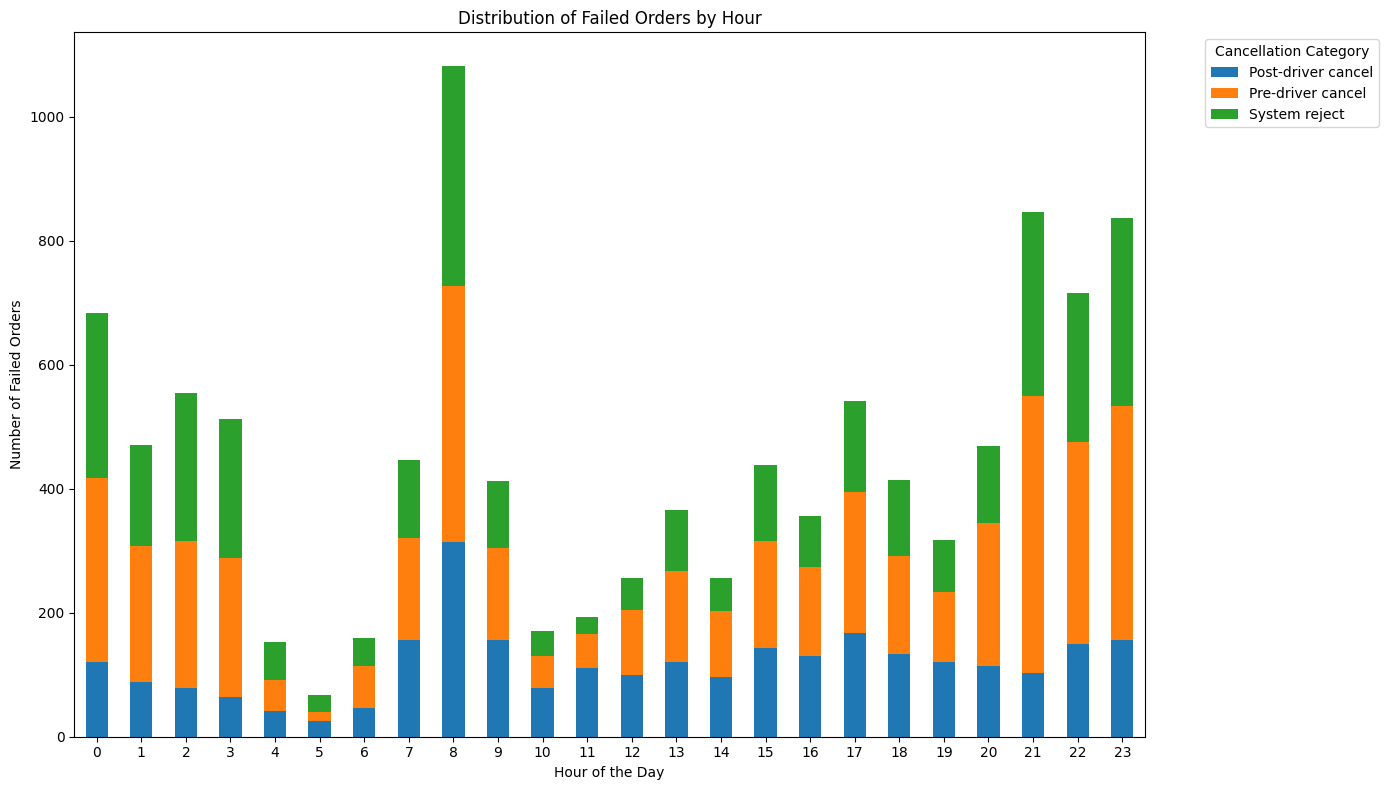

In [50]:
# 添加'order hour'列
orders['order_hour'] = orders['order_datetime'].dt.hour

# 添加取消状态码列
orders['cancel_status'] = 'Other'
orders.loc[(orders['is_driver_assigned_key'] == 0) & (orders['order_status_key'] == 4), 'cancel_status'] = 'Pre-driver cancel'
orders.loc[(orders['is_driver_assigned_key'] == 1) & (orders['order_status_key'] == 4), 'cancel_status'] = 'Post-driver cancel'
orders.loc[orders['order_status_key'] == 9, 'cancel_status'] = 'System reject'

# 按照小时和取消类别分组，计数订单
hourly_cancellation_counts = orders.groupby(['order_hour', 'cancel_status']).size().unstack(fill_value=0)

# 绘制堆叠柱状图以显示每个小时不同取消类别的分布
plt.figure(figsize=(14, 8))
hourly_cancellation_counts.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Distribution of Failed Orders by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Failed Orders')
plt.xticks(rotation=0)
plt.legend(title='Cancellation Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


从小时分布来说，取消订单的高峰在早上八点和晚上21点到23点之间达到高峰，这可能是因为这几个时间订单量大，车子少，打不到车的人多。然后10到11点的时候司机接单后的取消反常的多，可能这段时间的顾客比较不赶时间，所以下了订单后觉得打车比较贵于是决定坐地铁。

In [ ]:
# 检查异常值 - 使用IQR方法

<Figure size 1400x800 with 0 Axes>

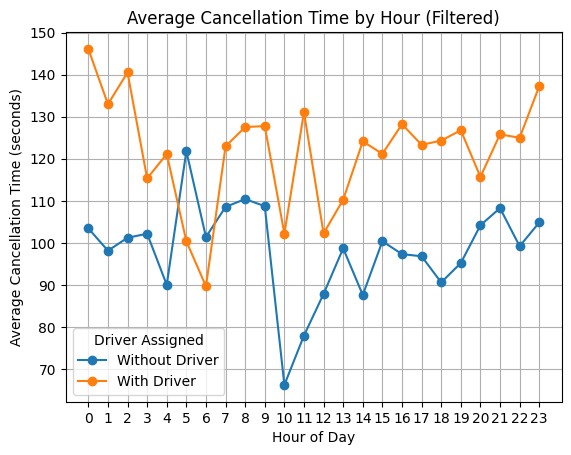

In [62]:
Q1 = orders['cancellations_time_in_seconds'].quantile(0.25)
Q3 = orders['cancellations_time_in_seconds'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 移除异常值
filtered_orders = orders[(orders['cancellations_time_in_seconds'] >= lower_bound) & 
                          (orders['cancellations_time_in_seconds'] <= upper_bound)]

#print(len(orders), len(filtered_orders))

# 按小时和失败原因分组，计算每个组的订单数量
grouped_avg_cancellation_time = filtered_orders.groupby(['is_driver_assigned_key', 'order_hour'])['cancellations_time_in_seconds'].mean().unstack(0)
grouped_avg_cancellation_time

# 可视化结果（移除异常值后的数据）
plt.figure(figsize=(14, 8))
grouped_avg_cancellation_time.plot(marker='o')
plt.title('Average Cancellation Time by Hour (Filtered)')
plt.ylabel('Average Cancellation Time (seconds)')
plt.xlabel('Hour of Day')
plt.xticks(range(0, 24))
plt.legend(['Without Driver', 'With Driver'], title='Driver Assigned')
plt.grid(True)
plt.show()

总体上来看，
有司机接单取消时间更长，可能是因为在有司机接单后，他们耐着性子多等了一段时间
而没有司机接单的人很快就没有耐心选择了取消

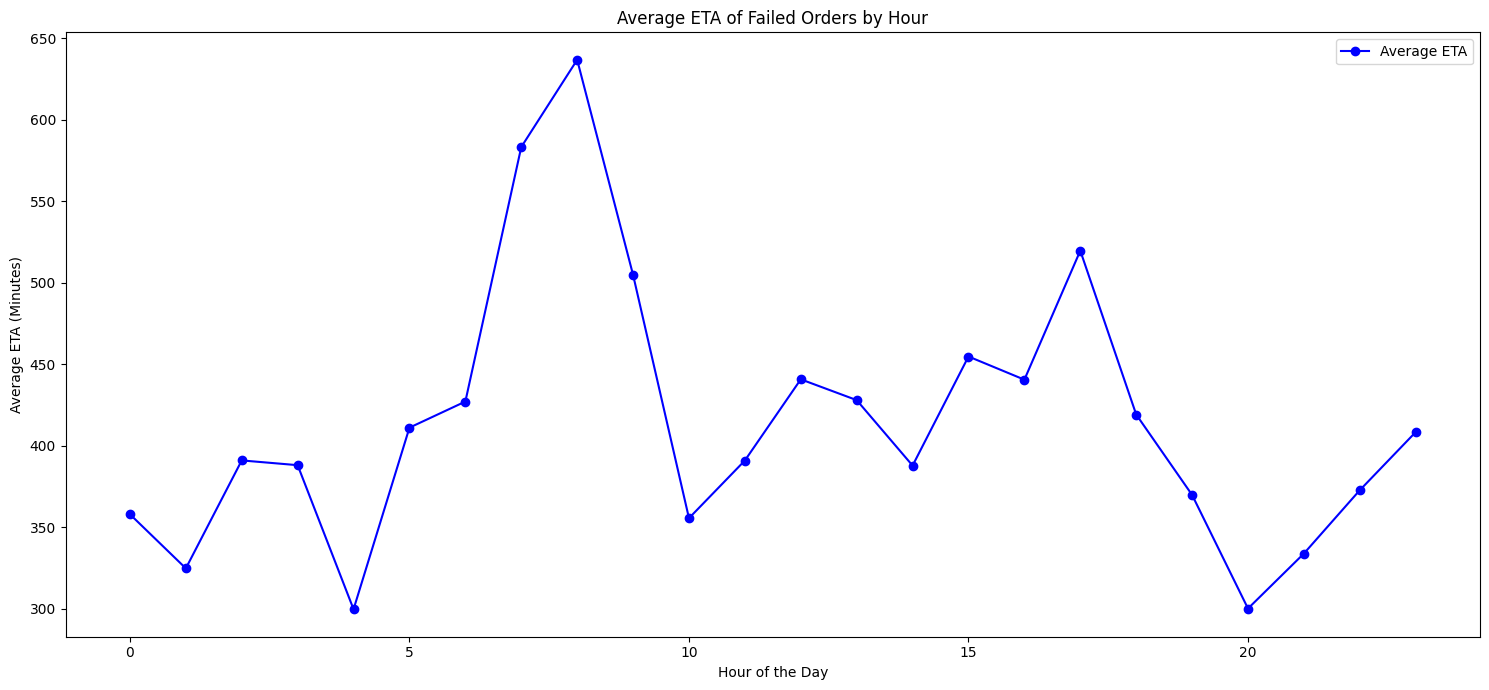

In [73]:
from matplotlib.ticker import MaxNLocator

# 按小时分组计算平均ETA
average_eta_by_hour = orders.groupby('order_hour')['m_order_eta'].mean()

# 绘制折线图
plt.figure(figsize=(15, 7))
average_eta_by_hour.plot(kind='line', color='blue', marker='o', label='Average ETA')

plt.title('Average ETA of Failed Orders by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average ETA (Minutes)')
plt.legend()
plt.tight_layout()
plt.show()


In [82]:
import pandas as pd
import h3
import folium
import branca.colormap as cm

orders['h3_code'] = orders.apply(lambda x: h3.geo_to_h3(x['origin_latitude'], x['origin_longitude'], 8), axis=1)

h3_counts = orders['h3_code'].value_counts()
h3_counts

total_orders = h3_counts.sum()
cumulative_counts = h3_counts.cumsum()
threshold = total_orders * 0.8
relevant_hexes = cumulative_counts[cumulative_counts <= threshold]
relevant_hexes

map_center = [orders['origin_latitude'].mean(), orders['origin_longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=14)

max_count = h3_counts.max()
min_count = h3_counts.min()

color_scale = cm.linear.YlOrRd_09.scale(min_count, max_count)

color_dict = {hex_id: color_scale(count) for hex_id, count in h3_counts.items()}

# 遍历relevant_hexes，为每个六边形添加多边形到地图
for hex_id in relevant_hexes.index:
    # 获取六边形的边界坐标
    boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    # 将边界坐标转换为folium接受的格式
    boundary_coordinates = [[coord[::-1] for coord in boundary]]  # 翻转每个坐标的纬度和经度
    # 获取当前六边形的颜色
    hex_color = color_dict[hex_id]
    # 添加多边形到地图
    folium.Polygon(boundary_coordinates,
                   color=hex_color,
                   weight=1,
                   fill=True,
                   fill_color=hex_color,
                   fill_opacity=0.7,
                   tooltip=f'Hex ID: {hex_id}, Count: {h3_counts[hex_id]}').add_to(m)

m.save('hex_map_colored.html')

可以看出平均到达时间在早高峰达到最大，并且下午也有一个晚高峰的出现

In [80]:
import pandas as pd
import h3
import folium
from branca.colormap import linear



# 创建 hex_id 列
orders['hex_id'] = orders.apply(
    lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], 8), axis=1)

# 计算每个 hexagon 中的订单数量
hex_counts = data_orders['hex_id'].value_counts().reset_index()
hex_counts.columns = ['hex_id', 'count']

# 创建颜色映射，颜色越深表示订单数量越多
max_count = hex_counts['count'].max()
colormap = linear.YlOrRd_09.scale(0, max_count)

# 初始化地图，选择一个适当的初始点和缩放级别
m = folium.Map(location=[orders['origin_latitude'].mean(), orders['origin_longitude'].mean()], zoom_start=12)

# 将 hexagons 添加到地图上
for _, row in hex_counts.iterrows():
    # 获取 hexagon 的边界
    hex_boundary = h3.h3_to_geo_boundary(row['hex_id'], geo_json=True)
    # 确定颜色
    color = colormap(row['count'])
    # 创建多边形并添加到地图
    folium.Polygon(
        locations=hex_boundary,
        color=color,
        weight=2,  # 设置边框宽度
        fill_color=color,
        fill_opacity=1.0,  # 设置填充不透明度
        popup=f'Orders: {row["count"]}'
    ).add_to(m)

# 在地图上添加颜色条
colormap.add_to(m)

# 显示地图
m.save('hexagon_map.html')

m